In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lets_plot import *
LetsPlot.setup_html()


from tqdm.notebook import tqdm

In [2]:
# from datalore.display import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [5]:
import itertools

In [13]:
def plot_digit(digit, size=8, caption=None):
    digit = digit.reshape(size, size)
    digit = (digit - np.min(digit))/(np.max(digit) - np.min(digit))
    p = ggplot() + geom_image(image_data=digit) + labs(x='', y='') \
        + theme(axis_line='blank', axis_title='blank', axis_ticks='blank', axis_text='blank')
    if caption:
        p += ggtitle(caption)
    return p;

In [14]:
def gg_confusion_matrix(y, y_hat):
    conf_mat = confusion_matrix(y, y_hat)[::-1]
    confusion_dat = pd.DataFrame(conf_mat)
    observed = confusion_dat.columns.values
    actual = confusion_dat.index.values
    xx, yy = np.meshgrid(actual, observed)
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    zz = conf_mat.reshape(-1)
    dat = {'predicted':xx, 'actual':yy[::-1], 'z':zz}
    p = ggplot(dat, aes('predicted', 'actual', fill='z')) \
        + geom_raster() \
        + geom_text(aes(label='z'), color='white')\
        + theme(legend_position='none', axis_ticks='blank', axis_line='blank')\
        + ggsize(500, 500) + scale_x_discrete() + scale_y_discrete()\
        + ggtitle('Confusion matrix')
    return p

In [15]:
def f1_score_micro(conf_matrix):
    num_tags = conf_matrix.shape[0]
    score = 0.
    pr, p, r = 0., 0., 0.
    for tag in range(num_tags):
        pr += conf_matrix[tag, tag]
        p += sum(conf_matrix[tag, :])
        r += sum(conf_matrix[:, tag])
    try:
        score = 2 * pr / (p + r)
    except ZeroDivisionError:
        pass
    return score

In [17]:
def plot_confusion_matrix(conf_matrix, labels, title='Confusion matrix', cmap='Oranges'):
    norm_cm = conf_matrix / conf_matrix.sum(axis=0)
    norm_cm[norm_cm != norm_cm] = .0  # eliminate NaN

    fig = Figure(figsize=(7, 7), dpi=120, facecolor='w', edgecolor='k')
    ax: Axes = fig.add_subplot(1, 1, 1)
    ax.set_title(label=title)

    ax.imshow(norm_cm, cmap=cmap)
    tick_marks = np.arange(len(labels))

    ax.set_xlabel('Actual', fontsize=7)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels, fontsize=6, rotation=-90, ha='center')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    ax.set_ylabel('Predicted', fontsize=7)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(labels, fontsize=6, va='center')
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()

    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        ax.text(j, i, format(int(conf_matrix[i, j]), 'd') if conf_matrix[i, j] != 0 else '.',
        horizontalalignment='center', verticalalignment='center', fontsize=6, color='black')
    fig.set_tight_layout('true')
    return fig

In [18]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [19]:
import matplotlib.ticker as ticker

In [20]:
import itertools

In [21]:
def plot_confusion_matrix(conf_matrix, labels, title='Confusion matrix', cmap: str='Oranges'):
    norm_cm = conf_matrix / conf_matrix.sum(axis=0)
    norm_cm[norm_cm != norm_cm] = .0  # eliminate NaN
    
    fig: Figure = Figure(figsize=(7, 7))
    ax: Axes = fig.add_subplot(1, 1, 1)
    ax.set_title(label=title)

    ax.matshow(norm_cm, cmap=cmap)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    ax.set_xticklabels([''] + labels, rotation=90)
    ax.set_yticklabels([''] + labels)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.grid(False)
    plt.tight_layout()

    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        ax.text(j, i, format(int(conf_matrix[i, j]), 'd') if conf_matrix[i, j] != 0 else '.',
                horizontalalignment='center', verticalalignment='center', fontsize=6, color='black')
    fig.set_tight_layout('true')
    return fig

In [22]:
from copy import copy
import inspect
import functools

In [23]:
from typing import List, Optional, Union, Callable
import json
import time

# Problem 2 (6.0) Model Distillation

На лекции мы упоминали Model Distillation в контексте DistillBert от HuggingFace. В этом задании вам предлагается применить дистилляцию к произвольной модели и попробовать добиться сокращения размера модели-ученика при почти полном сохранении качества по сравнению с моделью-учителем.

Посмотрите следующее [руководство](https://habr.com/ru/company/avito/blog/485290/) и попробуйте применить описанные идеи к какой-либо модели. Не обязательно брать BERT, вполне подойдет BiLSTM или что-то подобное, для чего известны метрики на каком-либо датасете.

Ссылки на GitHub или Colab c решением размещайте на этой странице. 

In [105]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

from torchvision import transforms, datasets
from torchvision.datasets import CIFAR10

In [106]:
def normalize_channel(image, eps=1e-4):
    nom = image.max() - image
    denom = image.max() - image.min()
    image_ = torch.zeros_like(image)
    if denom > 0:
        return nom / (denom + eps)
    else:
        return torch.zeros_like(image)

def normalize_image(image):
    image_ = torch.zeros_like(image)
    for i, channel in enumerate(image):
        image_[i] = normalize_channel(channel)
    return image_

In [107]:
def load_cifar10(train=True, data_path='./data'):
    transformers = []
    if train:
        transformers.extend([transforms.RandomHorizontalFlip(), transforms.RandomCrop(size=(32, 32), padding=4)])
    transformers.append(transforms.ToTensor())
    transformers.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    return CIFAR10(data_path, train=train, download=True, transform=transforms.Compose(transformers))

In [108]:
train = load_cifar10(train=True)
all_test = load_cifar10(train=False)

Files already downloaded and verified
Files already downloaded and verified


In [109]:
class SublistDataset(Dataset):
    def __init__(self, dataset, start, end):
        self.__dataset = dataset
        self.__start = start
        self.__end = end

    def __getitem__(self, index):
        return self.__dataset[index - self.__start]

    def __len__(self):
        return self.__end - self.__start

## Load data

In [110]:
# test = SublistDataset(all_test, 1000, 10000)
# dev = SublistDataset(all_test, 0, 1000)
# dev_small = SublistDataset(all_test, 0, 200)

dev_train = SublistDataset(train, 0, 5000)
# dev_train = train
dev_test = SublistDataset(all_test, 0, 200)


# print(f'train: {len(train)} test: {len(test)} dev: {len(dev)} dev_small: {len(dev_small)}')
print(f'train: {len(dev_train)}/{len(train)} test: {len(dev_test)}/{len(all_test)}')

train: 5000/50000 test: 200/10000


## Define ResNet

In [111]:
def make_conv(channels):
    return nn.Conv2d(channels, channels, kernel_size=(3, 3), stride=1, padding=1)

class SimpleBlock(nn.Module):
    def __init__(self, channels):
        super(SimpleBlock, self).__init__()
        self.conv1 = make_conv(channels)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = make_conv(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        c1 = F.relu(self.bn1(self.conv1(x)))
        c2 = self.bn2(self.conv2(c1))
        return F.relu(x + c2)

class DownBlock(nn.Module):
    def __init__(self, in_chan):
        super(DownBlock, self).__init__()
        self.out_chan = in_chan * 2
        self.conv1 = nn.Conv2d(in_chan, self.out_chan, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = make_conv(self.out_chan)
        self.bn2 = nn.BatchNorm2d(self.out_chan)
        self.conv_down = nn.Conv2d(in_chan, self.out_chan, kernel_size=(1, 1), stride=2, bias=False)
        self.bn_down = nn.BatchNorm2d(self.out_chan)

        self.bn_down.weight.data.fill_(1)
        self.bn_down.bias.data.fill_(0)

        self.bn1 = nn.BatchNorm2d(self.out_chan)

    def forward(self, x):
        c1 = F.relu(self.bn1(self.conv1(x)))
        c2 = self.bn2(self.conv2(c1))
        down = self.bn_down(self.conv_down(x))
        return F.relu(down + c2)

In [112]:
class ResNet(nn.Module):
    def __init__(self, n):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.seq32_32 = nn.Sequential()
        for i in range(n):
            self.seq32_32.add_module(str(i), SimpleBlock(16))

        self.seq16_16 = nn.Sequential()
        for i in range(n):
            if i == 0:
                self.seq16_16.add_module(str(i), DownBlock(16))
            else:
                self.seq16_16.add_module(str(i), SimpleBlock(32))

        self.seq8_8 = nn.Sequential()
        for i in range(n):
            if i == 0:
                self.seq8_8.add_module(str(i), DownBlock(32))
            else:
                self.seq8_8.add_module(str(i), SimpleBlock(64))

        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        s32_32 = self.seq32_32(x)
        s16_16 = self.seq16_16(s32_32)
        s8_8 = self.seq8_8(s16_16)

        features = F.avg_pool2d(s8_8, (8, 8))
        flat = features.view(features.size()[0], -1)

        return self.fc(flat)

In [113]:
loss = nn.CrossEntropyLoss()

def train_epoch(model, loader, opt):
    model.train(True)
    for i, data in enumerate(loader, 0):
        X, y = data[0], data[1]

        opt.zero_grad()
        y_ = model(X)
        loss_value = loss(y_.float(), y)
        loss_value.backward()
        opt.step()

def get_accuracy_on(model, dataset, batch=128):
    model.train(mode=False)

    loader = DataLoader(dataset, batch_size=batch)

    total_samples = 0
    total_correct = 0

    for batch in loader:
        X, y = batch[0], batch[1]

        y_ = model(X)
        _, y_ = torch.max(y_, dim=1)

        total_samples += len(y)
        sum_ = torch.sum(torch.eq(y_, y).type(torch.FloatTensor))
        total_correct += sum_.item()

    return total_correct / total_samples

def train_resnet(model, epochs=100, batch_size=128):
    opt = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
    #opt = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
    #opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    accuracies = []
    train_loader = DataLoader(dev_train, batch_size=batch_size)
    for epoch in tqdm(range(epochs)):
        if epoch == 40 or epoch == 80:
            for pg in opt.param_groups:
                pg['lr'] /= 10.0

        train_epoch(model, train_loader, opt)
        acc = get_accuracy_on(model, dev_test)
        accuracies.append(acc)
        print(f'\r epoch: [{epoch+1}/{epochs}], accuracy: {acc}', end='')
        
    total_acc = get_accuracy_on(model, all_test)
    print (f"\naccuracy on all_test: {total_acc}")
    return accuracies

## Choose student and teacher

In [114]:
student_model = ResNet(n=2) # RESNET-10
teacher_model = ResNet(n=5) # RESNET-22

## Train student without teacher

In [115]:
epochs=100
student_accuracies = train_resnet(student_model, epochs=epochs)

student_model = ResNet(n=2) # refresh student_model

  0%|          | 0/100 [00:00<?, ?it/s]

 epoch: [100/100], accuracy: 0.75accuracy on all_test: 0.7017


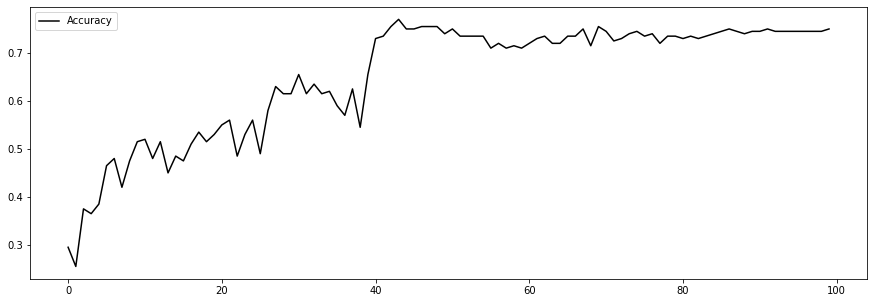

In [116]:
dat = pd.DataFrame({'a':student_accuracies})
dat['epoch'] = np.arange(epochs)

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(dat['epoch'], dat['a'], color='black', label='Accuracy')
ax.legend();

## Train teacher

In [117]:
epochs=100
# DEBUG! teacher_model = student_model
teacher_accuracies = train_resnet(teacher_model, epochs=epochs)
# DEBUG! teacher_accuracies = student_accuracies

  0%|          | 0/100 [00:00<?, ?it/s]

 epoch: [100/100], accuracy: 0.71accuracy on all_test: 0.7058


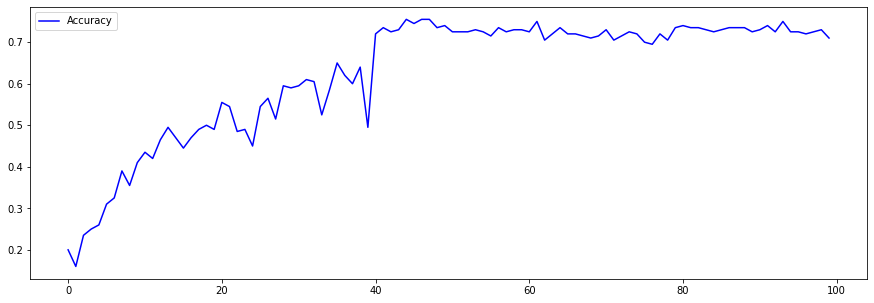

In [118]:
dat = pd.DataFrame({'a':teacher_accuracies})
dat['epoch'] = np.arange(epochs)

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(dat['epoch'], dat['a'], color='blue', label='Accuracy')
ax.legend();

In [122]:
def train_epoch_with_teacher(student_model, teacher_model, loader, opt, alpha=0.5):
    student_model.train(True)
    teacher_model.train(False)

    loss1 = nn.MSELoss()
    loss2 = nn.CrossEntropyLoss()

    for i, data in enumerate(loader, 0):
        X, y = data[0], data[1]

        opt.zero_grad()
        s_y_ = student_model(X)#.float()
        t_y_ = teacher_model(X)#.float()
        
        loss_value = alpha * loss2(s_y_, y) + (1 - alpha) * loss1(s_y_, t_y_)

        loss_value.backward()
        opt.step()

def train_resnet_with_teacher(student_model, teacher_model, epochs=100, batch_size=128):
    opt = optim.SGD(student_model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
    
    accuracies = []
    train_loader = DataLoader(dev_train, batch_size=batch_size)
    for epoch in tqdm(range(epochs)):
        if epoch == 40 or epoch == 80:
            for pg in opt.param_groups:
                pg['lr'] /= 10.0

        train_epoch_with_teacher(student_model, teacher_model, train_loader, opt)
        acc = get_accuracy_on(student_model, dev_test)
        accuracies.append(acc)
        print(f'\r epoch: [{epoch+1}/{epochs}], accuracy: {acc}', end='')
    
    total_acc = get_accuracy_on(student_model, all_test)
    print (f"\naccuracy on all_test: {total_acc}")
    return accuracies

## Train student with teacher

In [127]:
epochs=100
student_with_teacher_accuracies = train_resnet_with_teacher(student_model, teacher_model, epochs=epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

 epoch: [100/100], accuracy: 0.74
accuracy on all_test: 0.7286


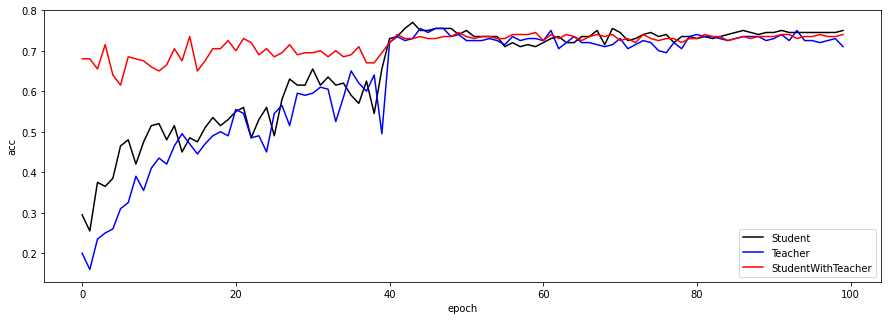

In [128]:
dat = pd.DataFrame({'t':teacher_accuracies, 's':student_accuracies, 
                    'st': student_with_teacher_accuracies})
dat['epoch'] = np.arange(epochs)

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(dat['epoch'], dat['s'], color='black', label='Student')
ax.plot(dat['epoch'], dat['t'], color='blue', label='Teacher')
ax.plot(dat['epoch'], dat['st'], color='red', label='StudentWithTeacher')
ax.set_ylabel("acc")
ax.set_xlabel("epoch")
ax.legend();